<a href="https://colab.research.google.com/github/BerpyDerpy/DeepTide-ML/blob/main/DeepTide_v0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install biopython

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 50.1 MB/s eta 0:00:00


In [ ]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from Bio import Entrez, SeqIO

# Settings
Entrez.email = "sairithwik2007@gmail.com"
NUM_SEQS_PER_CLASS = 25
CLASSES = ["Cnidaria", "Arthropoda", "Porifera", "Echinodermata"]
OUTPUT_CSV = "dna_dataset.csv"

SEQ_LENGTH = 300
BATCH_SIZE = 8
LEARNING_RATE = 0.001
EPOCHS = 20
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"


In [ ]:
from sklearn.cluster import KMeans, DBSCAN
from sklearn.manifold import TSNE

In [ ]:
def fetch_sequences(term, num_seqs):
    print(f"Searching for '{term}'...")
    handle = Entrez.esearch(db="nucleotide", term=term, retmax=num_seqs, idtype="acc")
    results = Entrez.read(handle)
    handle.close()
    id_list = results["IdList"]
    if not id_list: return ""
    handle = Entrez.efetch(db="nucleotide", id=id_list, rettype="fasta", retmode="text")
    records = handle.read()
    handle.close()
    return records


In [ ]:
if not os.path.exists(OUTPUT_CSV):
    print("Downloading dataset...")
    all_data = []
    for label in CLASSES:
        search_term = f'("{label}"[Organism]) AND 18S ribosomal RNA[Title] AND 1500:2500[Sequence Length]'
        fasta_data = fetch_sequences(search_term, NUM_SEQS_PER_CLASS)
        with open("temp.fasta", "w") as f: f.write(fasta_data)
        for record in SeqIO.parse("temp.fasta", "fasta"):
            all_data.append({"sequence": str(record.seq), "label": label})
        os.remove("temp.fasta")
    df = pd.DataFrame(all_data)
    df.to_csv(OUTPUT_CSV, index=False)

Searching for '("Cnidaria"[Organism]) AND 18S ribosomal RNA[Title] AND 1500:2500[Sequence Length]'...
Searching for '("Arthropoda"[Organism]) AND 18S ribosomal RNA[Title] AND 1500:2500[Sequence Length]'...
Searching for '("Porifera"[Organism]) AND 18S ribosomal RNA[Title] AND 1500:2500[Sequence Length]'...
Searching for '("Echinodermata"[Organism]) AND 18S ribosomal RNA[Title] AND 1500:2500[Sequence Length]'...


In [ ]:
def one_hot_encode(seq):
    mapping = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    encoded = np.zeros((4, len(seq)), dtype=np.float32)
    for i, base in enumerate(seq):
        if base in mapping:
            encoded[mapping[base], i] = 1.0
    return encoded

class DNADataset(Dataset):
    def __init__(self, dataframe, label_encoder):
        self.sequences = dataframe['sequence'].values
        self.labels = label_encoder.transform(dataframe['label'].values)

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        seq = self.sequences[idx]
        label = self.labels[idx]
        encoded_seq = one_hot_encode(seq)
        return torch.tensor(encoded_seq, dtype=torch.float32), torch.tensor(label, dtype=torch.long)


In [ ]:
df = pd.read_csv(OUTPUT_CSV)
df['sequence'] = df['sequence'].apply(lambda x: x[:SEQ_LENGTH].ljust(SEQ_LENGTH, 'N'))

classes = ['Cnidaria', 'Arthropoda', 'Porifera', 'Echinodermata']
print(classes)

label_encoder = LabelEncoder()
label_encoder.fit_transform(classes)
CLASSES = label_encoder.classes_
print(CLASSES)

train_df, val_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=42)

train_dataset = DNADataset(train_df, label_encoder)
val_dataset = DNADataset(val_df, label_encoder)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)


['Cnidaria', 'Arthropoda', 'Porifera', 'Echinodermata']
['Arthropoda' 'Cnidaria' 'Echinodermata' 'Porifera']


In [ ]:
class SimpleDNA_CNN(nn.Module):
    def __init__(self, num_classes=4, seq_length=SEQ_LENGTH):
        super(SimpleDNA_CNN, self).__init__()

        self.conv_layer = nn.Sequential(
            nn.Conv1d(in_channels=4, out_channels=32, kernel_size=5, padding=1),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2),
            )

        # Calculate the output size of the convolutional layer
        # Pass a dummy tensor through the conv_layer to determine the size
        dummy_input = torch.randn(1, 4, seq_length)
        with torch.no_grad():
            conv_output = self.conv_layer(dummy_input)
        conv_output_size = conv_output.view(1, -1).size(1)


        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(conv_output_size, 128),
            nn.ReLU(),
            nn.Linear(128, num_classes)
        )

    def forward(self,x):
      x = self.conv_layer(x)
      return self.classifier(x)

In [ ]:
model = SimpleDNA_CNN(num_classes=len(CLASSES)).to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

for epoch in range(EPOCHS):
  model.train()
  total_loss = 0
  for sequences, labels in train_loader:
    sequences, labels = sequences.to(DEVICE), labels.to(DEVICE)
    optimizer.zero_grad()
    outputs = model(sequences)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    total_loss += loss.item()
  print(f"EPOCHS: {epoch}, Loss: {total_loss/len(train_loader):.4f}")


EPOCHS: 0, Loss: 1.0783
EPOCHS: 1, Loss: 0.4972
EPOCHS: 2, Loss: 0.2262
EPOCHS: 3, Loss: 0.1234
EPOCHS: 4, Loss: 0.0664
EPOCHS: 5, Loss: 0.0238
EPOCHS: 6, Loss: 0.0155
EPOCHS: 7, Loss: 0.0074
EPOCHS: 8, Loss: 0.0059
EPOCHS: 9, Loss: 0.0045
EPOCHS: 10, Loss: 0.0039
EPOCHS: 11, Loss: 0.0033
EPOCHS: 12, Loss: 0.0030
EPOCHS: 13, Loss: 0.0027
EPOCHS: 14, Loss: 0.0024
EPOCHS: 15, Loss: 0.0022
EPOCHS: 16, Loss: 0.0020
EPOCHS: 17, Loss: 0.0018
EPOCHS: 18, Loss: 0.0017
EPOCHS: 19, Loss: 0.0016


In [ ]:
model.eval()
correct = 0
total = 0
with torch.no_grad():
  for sequences, labels in val_loader:
    sequences, labels = sequences.to(DEVICE), labels.to(DEVICE)
    outputs = model(sequences)
    _, predicted = torch.max(outputs.data, 1)
    total += len(labels)
    correct += (predicted == labels).sum().item()
accuracy = 100 * correct / total
print(f"Validation Accuracy: {accuracy:.2f}%")

Validation Accuracy: 90.00%


In [ ]:
class FeatureExtractor(nn.Module):
    def __init__(self, original_model):
        super(FeatureExtractor, self).__init__()
        # Using the convolutional part from the original model
        self.conv_layer = original_model.conv_layer

        # Using the first part of the classifier (up to the 128-dim layer)
        self.feature_layer = nn.Sequential(
            nn.Flatten(),
            original_model.classifier[1], # nn.Linear(conv_output_size, 128)
            original_model.classifier[2]  # nn.ReLU()
        )

    def forward(self, x):
        x = self.conv_layer(x)
        x = self.feature_layer(x)
        return x

In [ ]:
# Create the feature extractor and load the trained weights
feature_extractor = FeatureExtractor(model).to(DEVICE)
feature_extractor.eval()  # Set to evaluation mode
print("Feature extractor created.")

# Create a DataLoader for ALL data (train + val)
# In a real scenario, this would be new, unlabeled eDNA data
full_dataset = torch.utils.data.ConcatDataset([train_dataset, val_dataset])
full_loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False)

Feature extractor created.


In [ ]:
def get_single_sequence_embedding(sequence, extractor, seq_length, device="cpu"):
    """
    Preprocesses a single sequence string and gets its embedding using the extractor.

    Args:
        sequence (str): The DNA sequence string.
        extractor (nn.Module): The feature extractor model.
        seq_length (int): The expected sequence length for padding.
        device (str): The device to run the model on ('cuda' or 'cpu').

    Returns:
        numpy.ndarray: The embedding for the sequence.
    """
    # Apply the same padding as during training
    padded_seq = sequence[:seq_length].ljust(seq_length, 'N')

    # One-hot encode the padded sequence
    encoded_seq = one_hot_encode(padded_seq)

    # Convert to a PyTorch tensor and add a batch dimension
    input_tensor = torch.tensor(encoded_seq, dtype=torch.float32).unsqueeze(0).to(device)

    # Get the embedding using the extractor
    extractor.eval() # Ensure extractor is in eval mode
    with torch.no_grad():
        embedding = extractor(input_tensor)

    return embedding.cpu().numpy().squeeze() # Return as numpy array and remove batch dimension

# Example usage with your existing sequence string:
my_sequence_string = "TGAAGACCTAAGCCCATAGCCTACCTGCAATAACCCTAGGGTACCAAATCGTCCGGCTGAGGTCTTGACGAATACTACGGAAATAGTATGATTTAAAGCCGGGGTCTGATTTACATATGTTATCCAAAAGCGCGTGCTCCACGTACGTGACGGCTGTCCCTTCGAGGAATCAGGATTGCCCCGTGGATATTGGACATCTCCAAAAGCTATTCCGACCCTCCCGCCTCGAGAGAAACCGACTAGGCTCTAATCAGTGACTACAGAGTTCGCGCCTTAACAAAGCCCACCACCAGCTAGGCT"

# Use the feature_extractor created earlier (from cell yugxPExAIC_A)
# Ensure feature_extractor and DEVICE are available in the environment
if 'feature_extractor' in locals() and 'DEVICE' in locals() and 'SEQ_LENGTH' in locals():
    single_embedding = get_single_sequence_embedding(my_sequence_string, feature_extractor, SEQ_LENGTH, DEVICE)
    print(f"Embedding for the single sequence (shape: {single_embedding.shape}):")
    print(single_embedding[:10]) # Print first 10 elements as an example
else:
    print("Error: Required variables (feature_extractor, DEVICE, SEQ_LENGTH) not found.")
    print("Please ensure the cells defining these variables have been executed.")

In [ ]:
def get_embeddings(loader, extractor):
    """Utility function to extract embeddings and labels."""
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for sequences, labels in loader:
            sequences = sequences.to(DEVICE)

            # Get the embeddings
            embeddings = extractor(sequences)

            all_embeddings.append(embeddings.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    return np.concatenate(all_embeddings), np.concatenate(all_labels)

# Extract embeddings and corresponding true labels
print("Generating embeddings for all sequences...")
embeddings, true_labels = get_embeddings(full_loader, feature_extractor)
true_label_names = label_encoder.inverse_transform(true_labels)
print(f"Generated {embeddings.shape[0]} embeddings, each of dimension {embeddings.shape[1]}")

Generating embeddings for all sequences...
Generated 100 embeddings, each of dimension 128


In [ ]:
# 5. Apply K-Means clustering
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(embeddings)

# 6. Analyze K-Means results
# We can use a confusion matrix (crosstab) to see how well
# the unsupervised clusters map to the true labels.
cluster_analysis = pd.crosstab(true_label_names, kmeans_labels,
                               rownames=['True Label'],
                               colnames=['K-Means Cluster'])

print("\n--- K-Means Clustering Analysis ---")
print("This table shows how the true labels are distributed among the K-Means clusters.")
print(cluster_analysis)


--- K-Means Clustering Analysis ---
This table shows how the true labels are distributed among the K-Means clusters.
K-Means Cluster   0   1   2   3
True Label                     
Arthropoda        0  25   0   0
Cnidaria          0   0   2  23
Echinodermata    25   0   0   0
Porifera          0   0  25   0


In [ ]:
# 7. Apply DBSCAN
# You may need to tune 'eps' (max distance) and 'min_samples'
# 'eps' is the most important parameter to tune.
dbscan = DBSCAN(eps=0.7, min_samples=3) # These values are guesses
dbscan_labels = dbscan.fit_predict(embeddings)

# 8. Analyze DBSCAN results
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"\n--- DBSCAN Clustering Analysis ---")
print(f"Found {n_clusters} distinct clusters.")
print(f"Identified {n_noise} sequences as outliers (noise).")

# 9. Identify the "New Discoveries"
# These outliers are the sequences that don't fit well with any
# of the known phyla.
outlier_indices = np.where(dbscan_labels == -1)[0]
outlier_sequences = df.iloc[outlier_indices]['sequence'].values
outlier_true_labels = true_label_names[outlier_indices]

print(f"\nPotential Novel Discoveries (Outliers):")
for i in range(len(outlier_indices)):
    print(f"  - Index: {outlier_indices[i]}, Original Label: {outlier_true_labels[i]}")

# Note: Since we are using data we trained on, most sequences *should*
# fit a cluster. The outliers here are likely just "weird" examples
# from our known classes. In a REAL experiment with new eDNA,
# the outliers would be the truly unknown sequences.


--- DBSCAN Clustering Analysis ---
Found 8 distinct clusters.
Identified 51 sequences as outliers (noise).

Potential Novel Discoveries (Outliers):
  - Index: 0, Original Label: Porifera
  - Index: 3, Original Label: Porifera
  - Index: 8, Original Label: Cnidaria
  - Index: 9, Original Label: Cnidaria
  - Index: 12, Original Label: Echinodermata
  - Index: 13, Original Label: Porifera
  - Index: 18, Original Label: Porifera
  - Index: 21, Original Label: Cnidaria
  - Index: 27, Original Label: Porifera
  - Index: 30, Original Label: Porifera
  - Index: 32, Original Label: Cnidaria
  - Index: 33, Original Label: Porifera
  - Index: 34, Original Label: Porifera
  - Index: 35, Original Label: Porifera
  - Index: 38, Original Label: Cnidaria
  - Index: 39, Original Label: Porifera
  - Index: 40, Original Label: Echinodermata
  - Index: 41, Original Label: Arthropoda
  - Index: 43, Original Label: Echinodermata
  - Index: 45, Original Label: Porifera
  - Index: 46, Original Label: Echinod


Running t-SNE... (this may take a moment)


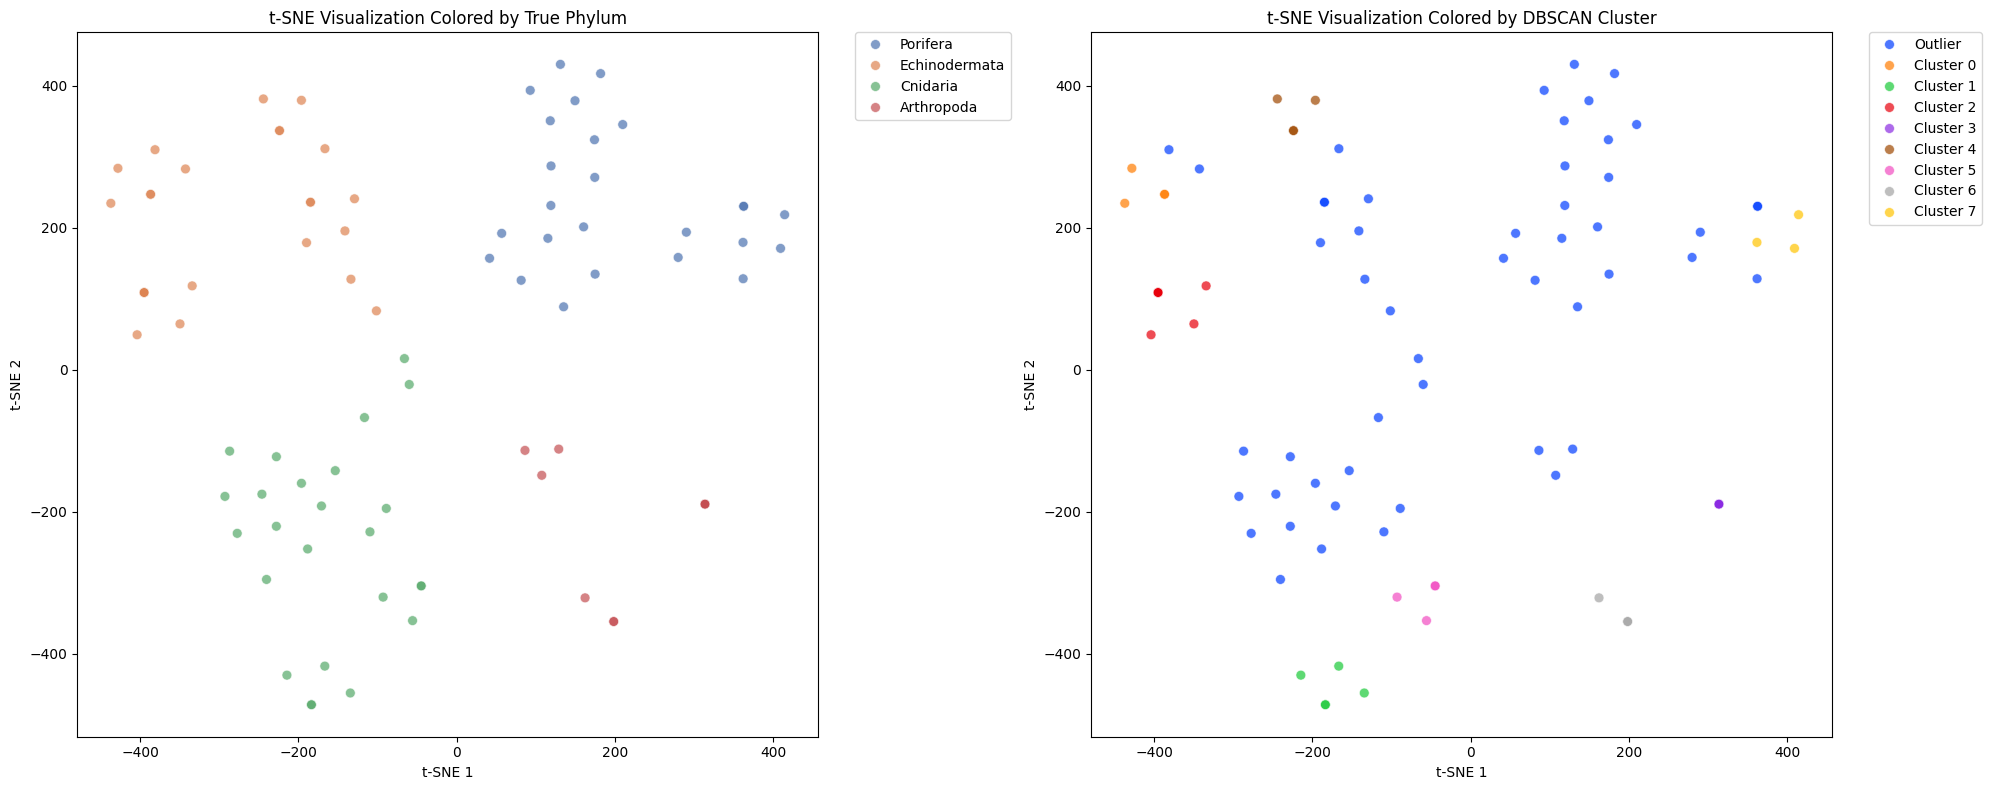

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# 10. Apply t-SNE for 2D visualization
print("\nRunning t-SNE... (this may take a moment)")
tsne = TSNE(n_components=2, random_state=42, perplexity=10)
embeddings_2d = tsne.fit_transform(embeddings)

# 11. Create a visualization DataFrame
vis_df = pd.DataFrame(data=embeddings_2d, columns=['t-SNE 1', 't-SNE 2'])
vis_df['True Label'] = true_label_names
vis_df['DBSCAN Cluster'] = [f'Cluster {l}' if l != -1 else 'Outlier' for l in dbscan_labels]

# 12. Plot the results
plt.figure(figsize=(20, 8))

# Plot 1: Colored by True Label (Ground Truth)
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=vis_df,
    x='t-SNE 1', y='t-SNE 2',
    hue='True Label',
    palette='deep',
    s=50,
    alpha=0.7
)
plt.title('t-SNE Visualization Colored by True Phylum')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Plot 2: Colored by DBSCAN Cluster (Discovery)
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=vis_df,
    x='t-SNE 1', y='t-SNE 2',
    hue='DBSCAN Cluster',
    palette='bright',
    s=50,
    alpha=0.7
)
plt.title('t-SNE Visualization Colored by DBSCAN Cluster')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()

In [ ]:
pip install umap-learn


Running UMAP...


/usr/local/lib/python3.12/dist-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


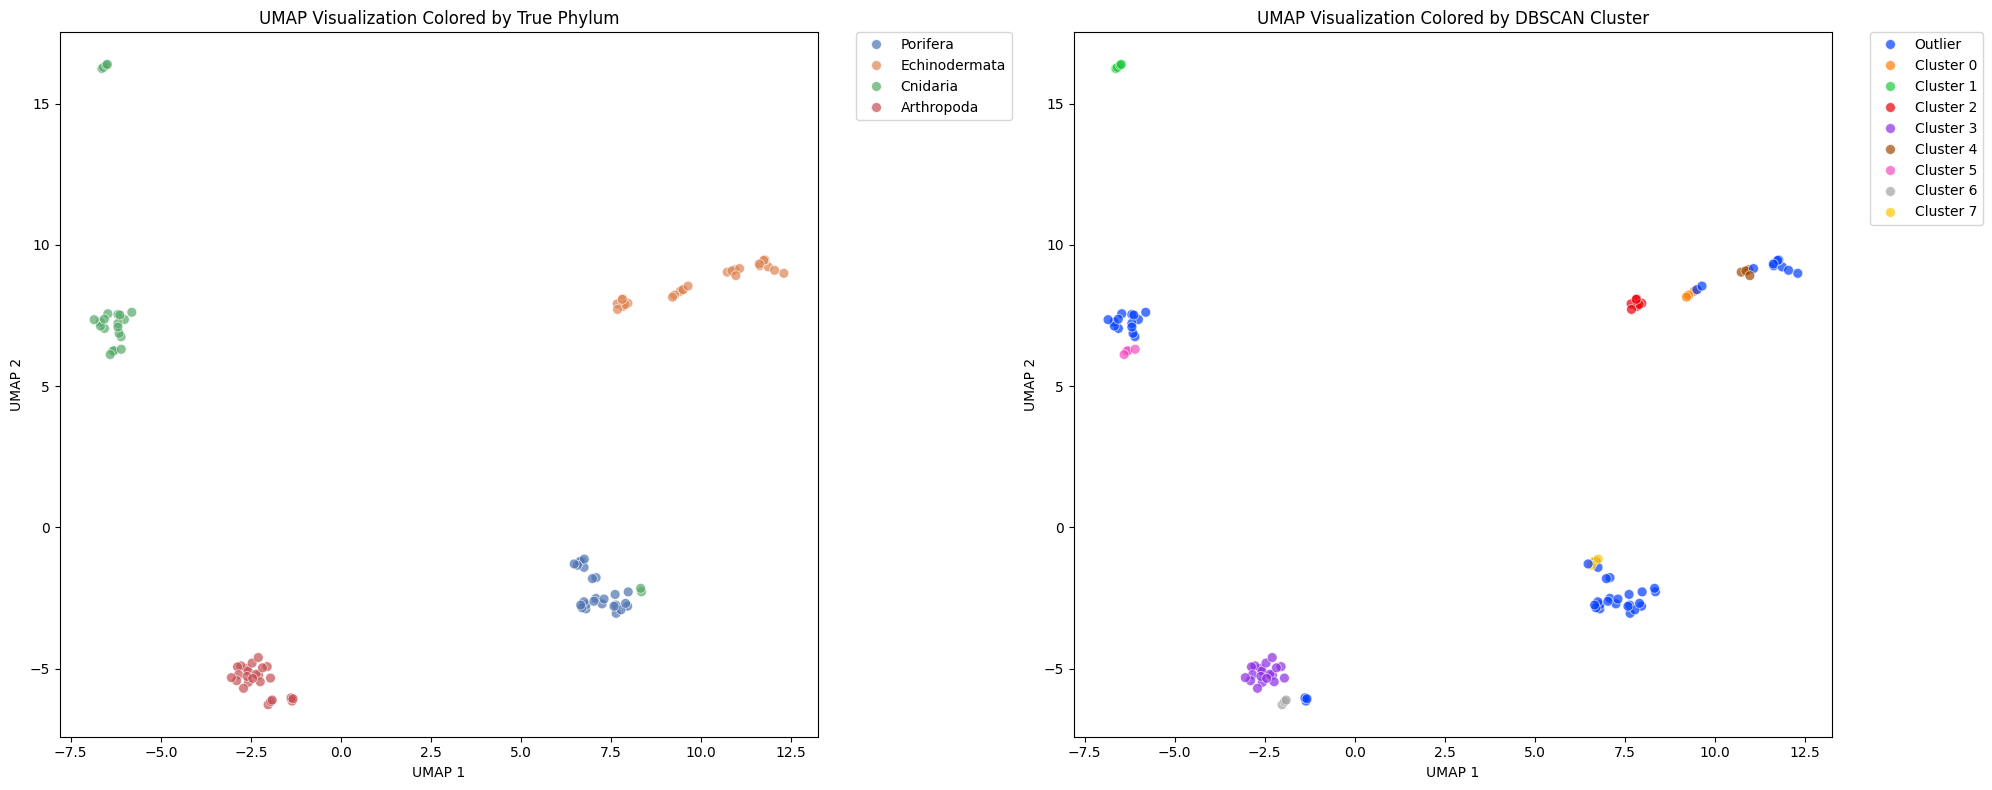

In [ ]:
import umap

# 10. Apply UMAP for 2D visualization
print("\nRunning UMAP...")
# Key parameters:
# n_neighbors: Controls the balance between local and global structure.
# min_dist: Controls how tightly packed points are allowed to be.
reducer = umap.UMAP(n_neighbors=15, min_dist=0.1, random_state=42)
embeddings_2d = reducer.fit_transform(embeddings)

# 11. Create a visualization DataFrame
vis_df = pd.DataFrame(data=embeddings_2d, columns=['UMAP 1', 'UMAP 2'])
vis_df['True Label'] = true_label_names
vis_df['DBSCAN Cluster'] = [f'Cluster {l}' if l != -1 else 'Outlier' for l in dbscan_labels]

# 12. Plot the results
plt.figure(figsize=(20, 8))

# Plot 1: Colored by True Label (Ground Truth)
plt.subplot(1, 2, 1)
sns.scatterplot(
    data=vis_df,
    x='UMAP 1', y='UMAP 2',
    hue='True Label',
    palette='deep',
    s=50,
    alpha=0.7
)
plt.title('UMAP Visualization Colored by True Phylum')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

# Plot 2: Colored by DBSCAN Cluster (Discovery)
plt.subplot(1, 2, 2)
sns.scatterplot(
    data=vis_df,
    x='UMAP 1', y='UMAP 2',
    hue='DBSCAN Cluster',
    palette='bright',
    s=50,
    alpha=0.7
)
plt.title('UMAP Visualization Colored by DBSCAN Cluster')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.tight_layout()
plt.show()

In [ ]:
torch.save(model.state_dict(), "dna_classifier.pth")

In [ ]:
model = SimpleDNA_CNN()

model.load_state_dict(torch.load("DeepTide_v0.pth", map_location=torch.device('cpu')))
model.eval()
classes = ['Cnidaria', 'Arthropoda', 'Porifera', 'Echinodermata']
label_encoder = LabelEncoder()
label_encoder.fit_transform(classes)
CLASSES = label_encoder.classes_
print(CLASSES)

In [ ]:
seq ="TGAAGACCTAAGCCCATAGCCTACCTGCAATAACCCTAGGGTACCAAATCGTCCGGCTGAGGTCTTGACGAATACTACGGAAATAGTATGATTTAAAGCCGGGGTCTGATTTACATATGTTATCCAAAAGCGCGTGCTCCACGTACGTGACGGCTGTCCCTTCGAGGAATCAGGATTGCCCCGTGGATATTGGACATCTCCAAAAGCTATTCCGACCCTCCCGCCTCGAGAGAAACCGACTAGGCTCTAATCAGTGACTACAGAGTTCGCGCCTTAACAAAGCCCACCACCAGCTAGGCT"
encoded_seq = one_hot_encode(seq)
input_tensor = torch.tensor(encoded_seq, dtype=torch.float32).unsqueeze(0).to("cpu")

model.eval()
with torch.no_grad():
    output = model(input_tensor)
    _, predicted_class = torch.max(output, 1)
    probabilities = torch.softmax(output, dim=1)
    confidence = probabilities[0][predicted_class].item()*100

print(output)
print(probabilities)
predicted_label = label_encoder.inverse_transform(predicted_class.cpu().numpy())
print("Predicted class:", predicted_label[0])
print(f"Confidence: {confidence:.4f}")